In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plot_params import *
from pathlib import Path
import numpy as np
circ_quant_output = []
# indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
# indir = '/home/hsher/scratch/circ_truseq_iter2/output/'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
# indir = '/home/hsher/scratch/circ_nextera/output/'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
# indir = '/home/hsher/scratch/circ_truseq/output/'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
# indir = '/home/hsher/scratch/circSTAMP_iter1/output'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
# indir = '/home/hsher/scratch/circ_nextera_iter3/output'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
# indir = '/home/hsher/scratch/circ_truseq_iter3/output/'
# circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/projects/ps-yeolab5/hsher/circ_outputs'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]

In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
rename_dict = {
               #### included
               'circseq-bm-rar11-nxt': 'rar11_rep1', 
               'HEK_rar11': 'rar11_rep2', 
               
               'circseq-bm-rar': 'rar_rep1',
               'HEK_rar': 'rar_rep2', 
               
               'circseq-bm-arr': 'arr_rep1', 
               'HEK_arr':'arr_rep2',
               
               'circseq-bm-rz': 'rz_rep1', 
               'HEK_rz':'rz_rep2',
               ### included
               }
group_color = {
              'rar11': 'orange',
              
              'rz': 'mediumorchid', 
              'rar': 'seagreen',
              'arr': 'royalblue'}

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']
for fname in circ_quant_output:
    
    
    name = os.path.basename(fname).replace('.gtf', '')
    if name in rename_dict.keys():
        names.append(name)

        circ_df, stat = read_ciri_gtf(fname)

        circ_type_count.append(circ_df['circ_type'].value_counts())

        junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
        bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
        fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
        stats.append(stat.set_index(0))
        
        
        
    
        mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()


In [5]:
stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

stats_df = stats_df.drop_duplicates('##Sample').set_index('##Sample')
stats_df = stats_df.rename(rename_dict).sort_index()
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

names = [rename_dict[c] if c in rename_dict.keys() else c for c in names ]



In [6]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names
counts = counts.T.reset_index().drop_duplicates('index').set_index('index')

In [7]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names
bsj=bsj.T.reset_index().drop_duplicates('index').set_index('index').T
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names
fsj=fsj.T.reset_index().drop_duplicates('index').set_index('index').T
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names
junc=junc.T.reset_index().drop_duplicates('index').set_index('index').T

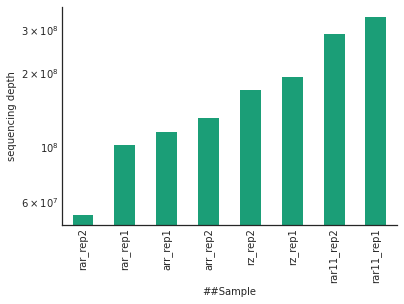

In [8]:
stats_df['##Total_Reads'].sort_values().plot.bar()
plt.ylabel('sequencing depth')
plt.yscale('log')
sns.despine()

In [9]:
figure1_sets = [ 
              'rz_rep1','rz_rep2',
             'arr_rep1','arr_rep2',
              'rar_rep1', 'rar_rep2',
              'rar11_rep1','rar11_rep2'
             ]

In [10]:
figure1_colors = [group_color[c.split('-')[0].split('_rep')[0]] for c in figure1_sets]

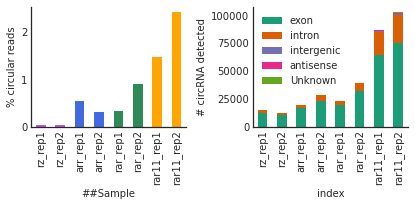

In [11]:
f, ax = plt.subplots(1,2, figsize = (6,3))
(stats_df.loc[figure1_sets, 'frac_circular']*100).plot.bar(
    color = figure1_colors, ax = ax[0])
ax[0].set_ylabel('% circular reads')




counts.loc[figure1_sets].plot.bar(stacked = True, ax = ax[1])
ax[1].set_ylabel('# circRNA detected')
sns.despine()
plt.tight_layout()
plt.savefig(figdir / '1_perc_circle.pdf')

# Enrichment as measured by junction ratio

In [12]:
from scipy.stats import pearsonr

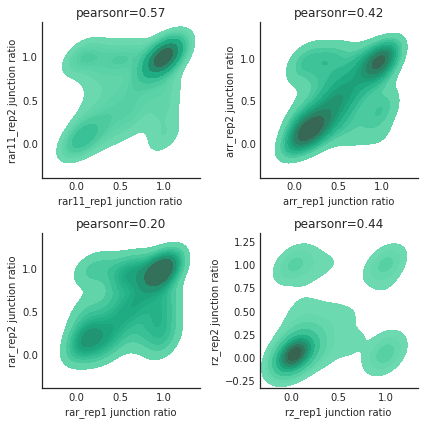

In [13]:
f, axes = plt.subplots(2,2, figsize = (6,6))
sub_junc = junc.loc[~(junc['rz_rep1'].isnull())&~(junc['rz_rep2'].isnull())]

for protocol, ax in zip(['rar11', 'arr', 'rar', 'rz'], axes.flatten()):
    sns.kdeplot(data = sub_junc.sample(500), x = f'{protocol}_rep1', y = f'{protocol}_rep2', fill = True, ax = ax)
    r,p = pearsonr(sub_junc[f'{protocol}_rep1'].fillna(0),sub_junc[f'{protocol}_rep2'].fillna(0))
    ax.set_title(f'pearsonr={r:.2f}')
    ax.set_xlabel(f'{protocol}_rep1 junction ratio')
    ax.set_ylabel(f'{protocol}_rep2 junction ratio')
# sns.kdeplot(data = sub_junc.sample(500), x = 'arr_rep1', y = 'arr_rep2', fill = True, ax = ax[0,1])
# sns.kdeplot(data = sub_junc.sample(500), x = 'rar_rep1', y = 'rar_rep2', fill = True, ax = ax[1,0])
# sns.kdeplot(data = sub_junc.sample(500), x = 'rz_rep1', y = 'rz_rep2', fill = True, ax = ax[1,1])
sns.despine()
plt.tight_layout()
plt.savefig(figdir / '1_junc_ratio_reproducibility.pdf')

In [14]:
sub_junc_t = sub_junc.T.copy()
sub_junc_t['protocol']=pd.Series(sub_junc.columns).str.split('_', expand = True)[0].tolist()
avg_junc = sub_junc_t.groupby(by = 'protocol').mean().T

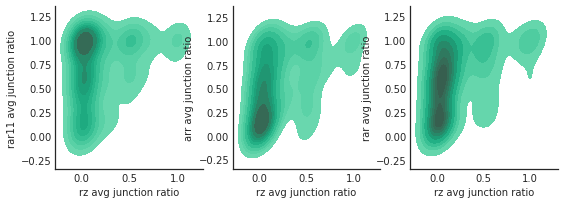

In [15]:
f, axes = plt.subplots(1,3, figsize = (9,3))
for protocol, ax in zip(['rar11', 'arr', 'rar'], axes):
    
    sns.kdeplot(data = avg_junc.sample(500), x = f'rz', y = f'{protocol}', fill = True, ax = ax)
    ax.set_xlabel(f'rz avg junction ratio')
    ax.set_ylabel(f'{protocol} avg junction ratio')
    
    #r,p = pearsonr(sub_junc[f'{protocol}_rep1'].fillna(0),sub_junc[f'{protocol}_rep2'].fillna(0))
    #ax.set_title(f'pearsonr={r:.2f}')
sns.despine()
plt.savefig(figdir / '1_junc_ratio_vs_rz.pdf')

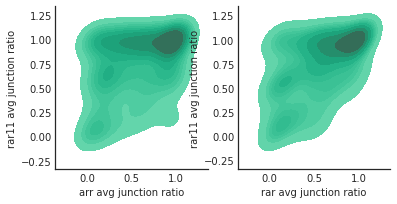

In [16]:
f, axes = plt.subplots(1,2, figsize = (6,3))
for protocol, ax in zip(['arr', 'rar'], axes):
    
    sns.kdeplot(data = avg_junc.sample(500), y = f'rar11', x = f'{protocol}', fill = True, ax = ax)
    ax.set_ylabel(f'rar11 avg junction ratio')
    ax.set_xlabel(f'{protocol} avg junction ratio')
    
    #r,p = pearsonr(sub_junc[f'{protocol}_rep1'].fillna(0),sub_junc[f'{protocol}_rep2'].fillna(0))
    #ax.set_title(f'pearsonr={r:.2f}')
sns.despine()
plt.savefig(figdir / '1_junc_ratio_vs_other.pdf')

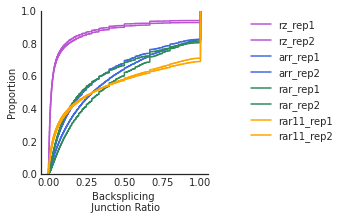

In [17]:
f, ax = plt.subplots(figsize = (3,3))
for col, color in zip(figure1_sets, figure1_colors):
    ax = sns.ecdfplot(data =junc[col].to_frame(), x = col, ax = ax, label = col, color = color)
    ax.set_xlabel('Backsplicing \n Junction Ratio')
ax.legend(bbox_to_anchor = (1.2,1))
#sns.move_legend(ax, "center right")
sns.despine()

In [18]:
avg_junc.loc[avg_junc['rz']>0, 'rz'].min()

0.0005

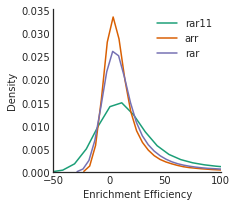

In [19]:
enrichment_eff = avg_junc.loc[avg_junc['rz']>0].div(avg_junc.loc[avg_junc['rz']>0, 'rz'], axis = 0)
f, ax = plt.subplots(figsize = (3,3))
for protocol in ['rar11', 'arr', 'rar']:
    sns.kdeplot(data = enrichment_eff.fillna(0), x = protocol, label = protocol, ax = ax)
ax.legend()
ax.set_xlabel('Enrichment Efficiency')
ax.set_xlim(-50,100)
sns.despine()
plt.savefig(figdir / '1_enrichment_eff.pdf')

# Accuracy

In [20]:
circname = {}
for name in bsj.columns:
    circname[name] = set(bsj[name].dropna().index)

In [21]:
circname_reproducible = {}
for protocol in ['rar11', 'arr', 'rar', 'rz']:
    circname_reproducible[protocol]=circname[f'{protocol}_rep1'].intersection(circname[f'{protocol}_rep2'])

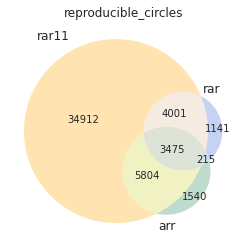

In [22]:
from matplotlib_venn import venn3
venn3([circname_reproducible[p] for p in ['rar11', 'arr', 'rar']]
      , set_labels = ('rar11', 'rar', 'arr'), 
      set_colors = (group_color[p] for p in ['rar11', 'arr', 'rar']),
      alpha = 0.3
     )
plt.title('reproducible_circles')
plt.savefig(figdir / '1_venn_3procotol.pdf')

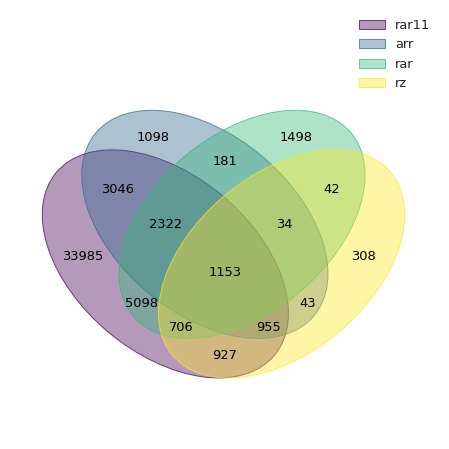

In [23]:
from venn import venn
venn(circname_reproducible)
plt.savefig(figdir / '1_venn_4procotol.pdf')

In [24]:
from scipy.stats import pearsonr
def get_pearsonr_dropna(df, col1, col2):
    sub = df[[col1, col2]].dropna()
    r,p=pearsonr(sub[col1], sub[col2])
    return r,p

In [25]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

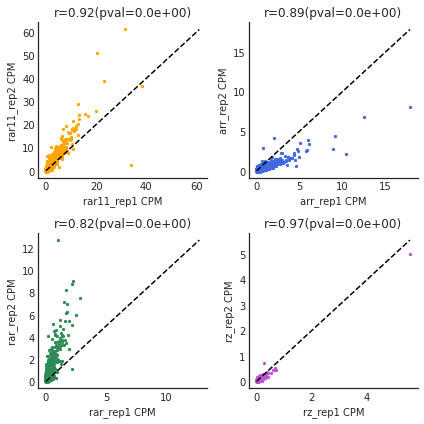

In [26]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for protocol, ax in zip(['rar11', 'arr', 'rar', 'rz'], axes.flatten()):

    cpm.plot.scatter(x = f'{protocol}_rep1', y = f'{protocol}_rep2', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(cpm, f'{protocol}_rep1', f'{protocol}_rep2')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'{protocol}_rep1 CPM')
    ax.set_ylabel(f'{protocol}_rep2 CPM')
    ax.plot([0, max(cpm[f'{protocol}_rep1'].max(), cpm[f'{protocol}_rep2'].max())],
            [0, max(cpm[f'{protocol}_rep1'].max(), cpm[f'{protocol}_rep2'].max())],
            '--',
           color = 'black'
           )


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '1_CPM_reproducibility.pdf')

In [27]:
cpm_t = cpm.loc[(cpm['rz_rep1']>0)&(cpm['rz_rep2']>0)].T.copy()
cpm_t['protocol']=pd.Series(cpm.columns).str.split('_', expand = True)[0].tolist()
avg_cpm = cpm_t.groupby(by = 'protocol').mean().T

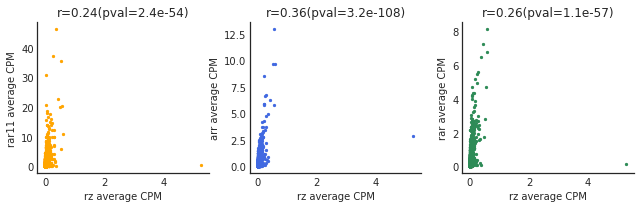

In [28]:
f, axes = plt.subplots(1,3, figsize = (9,3))
for protocol, ax in zip(['rar11', 'arr', 'rar'], axes.flatten()):

    avg_cpm.plot.scatter(y = f'{protocol}', x = f'rz', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rz')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rz average CPM')
    ax.set_ylabel(f'{protocol} average CPM')


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '1_CPM_corr_w_rz.pdf')

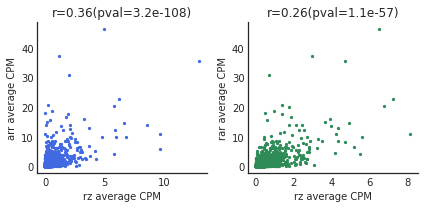

In [29]:
f, axes = plt.subplots(1,2, figsize = (6,3))
for protocol, ax in zip(['arr', 'rar'], axes.flatten()):

    avg_cpm.plot.scatter(x = f'{protocol}', y = f'rar11', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rz')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rz average CPM')
    ax.set_ylabel(f'{protocol} average CPM')


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '1_CPM_corr_w_other.pdf')

In [30]:
mionco_df = pd.read_csv('/projects/ps-yeolab5/hsher/mioncocirc/v0.1.release.txt', sep = '\t')
mionco_df['circ_id']=mionco_df['chr']+':'+(mionco_df['start']+1).astype(str)+'|'+mionco_df['end'].astype(str)

In [31]:

detected_t = ~bsj.isnull().T
detected_t['protocol']=pd.Series(bsj.columns).str.split('_', expand = True)[0].tolist()
detected_both = detected_t.groupby(by = 'protocol').all().T
detected_both.columns = ['detected_'+c for c in detected_both.columns]

In [32]:
mega = pd.concat([detected_both, cpm, mega_anno], axis = 1)

In [33]:
mega['is_miOncoCirc']=mega.index.isin(mionco_df['circ_id'])

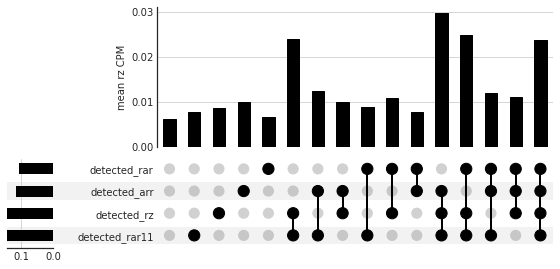

In [34]:
from upsetplot import plot
plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_')])['rz_rep1'].mean(),
    )
plt.ylabel('mean rz CPM')
plt.savefig(figdir / '1_mean_CPM_upset.pdf')

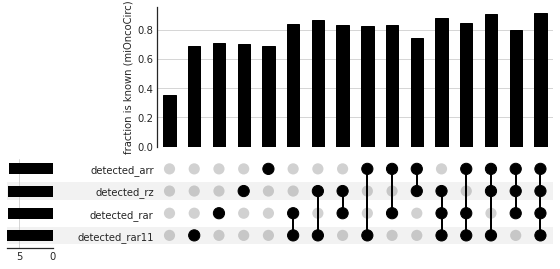

In [35]:

plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_')])['is_miOncoCirc'].mean(),
    )
plt.ylabel('fraction is known (miOncoCirc)')
plt.savefig(figdir / '1_fraction_miOncoCirc.pdf')

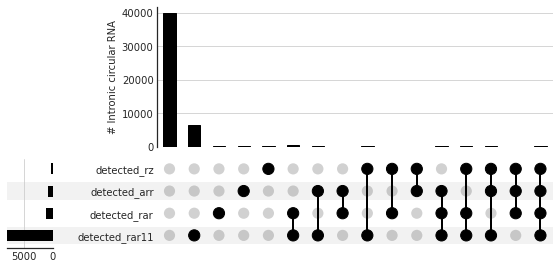

In [36]:

type_cnt = mega.groupby(by = [c for c in mega.columns if c.startswith('detected_')]
            )['circ_type'].value_counts().unstack().fillna(0)
plot(type_cnt['intron'],
    )
plt.ylabel('# Intronic circular RNA')
plt.savefig(figdir / '1_n_intronic.pdf')

# Downsampling

In [37]:
from pathlib import Path
downsample_dir = Path('/home/hsher/scratch/downsample_ciri/output/')

In [38]:
data = []
for fname in downsample_dir.glob('*.gtf'):
    name, depth,_ = fname.name.split('.')
    depth = int(depth)
    circ_df, stat = read_ciri_gtf(fname)
    cnt = circ_df['circ_type'].value_counts()
    value = pd.concat([stat.set_index(0)[1], cnt])
    value['name'] = name
    value['depth']=depth
    data.append(value)
data = pd.concat(data, axis =1).T

In [39]:
data[[ '##Total_Reads',
 '##Mapped_Reads',
 '##Circular_Reads']]=data[[ '##Total_Reads',
 '##Mapped_Reads',
 '##Circular_Reads']].astype(int)

In [40]:
group_color

{'rar11': 'orange',
 'rz': 'mediumorchid',
 'rar': 'seagreen',
 'arr': 'royalblue'}

In [41]:
rename_dict

{'circseq-bm-rar11-nxt': 'rar11_rep1',
 'HEK_rar11': 'rar11_rep2',
 'circseq-bm-rar': 'rar_rep1',
 'HEK_rar': 'rar_rep2',
 'circseq-bm-arr': 'arr_rep1',
 'HEK_arr': 'arr_rep2',
 'circseq-bm-rz': 'rz_rep1',
 'HEK_rz': 'rz_rep2'}

In [42]:
data

,##Sample,##Total_Reads,##Mapped_Reads,##Circular_Reads,##version,exon,intron,intergenic,antisense,Unknown,name,depth
0,100_rar16_re.1000000,2000000,1714946,32464,1.1.2,5496,743,31,17,1,100_rar16_re,1000000
1,circseq-bm-arr.50000000,100000000,87140744,470642,1.1.2,16074,3102,110,73,2,circseq-bm-arr,50000000
2,circseq-bm-rar.10000,20000,18452,62,1.1.2,31,NaN,NaN,NaN,NaN,circseq-bm-rar,10000
3,circseq-bm-rz.50000000,100000000,94660266,36754,1.1.2,8132,1389,63,26,1,circseq-bm-rz,50000000
4,HEK_arr.100000000,130988984,112930290,338246,1.1.2,23220,4722,206,112,1,HEK_arr,100000000
...,...,...,...,...,...,...,...,...,...,...,...,...
64,HEK_arr.30000000,60000000,51707284,157338,1.1.2,17432,3259,135,82,1,HEK_arr,30000000
65,100_rar16_re.50000000,100000000,86324532,1631508,1.1.2,23338,4768,234,161,3,100_rar16_re,50000000
66,HEK_rz.10000,20000,18510,2,1.1.2,NaN,1,NaN,NaN,NaN,HEK_rz,10000
67,500_rar14_re.10000,20000,16742,334,1.1.2,145,10,2,NaN,NaN,500_rar14_re,10000


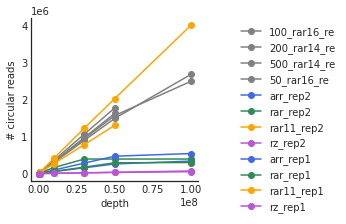

In [43]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    try:
        group.plot(x = 'depth', y = '##Circular_Reads', ax = ax, 
                   label = rename_dict[name], marker = 'o',
                  color =group_color[rename_dict[name].split('_')[0]])
    except:
        group.plot(x = 'depth', y = '##Circular_Reads', ax = ax, 
                   label = name, marker = 'o',
                  color ='grey')
    sns.despine()
ax.set_ylabel('# circular reads')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_circ_read.pdf')

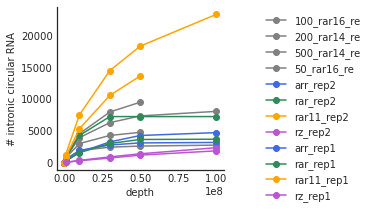

In [44]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    try:
        group.plot(x = 'depth', y = 'intron', ax = ax, 
                   label = rename_dict[name], marker = 'o',
                  color =group_color[rename_dict[name].split('_')[0]])
    except:
        group.plot(x = 'depth', y = 'intron', ax = ax, 
                   label = name, marker = 'o',
                  color ='grey')
    sns.despine()
ax.set_ylabel('# intronic circular RNA')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_intronic_circ.pdf')

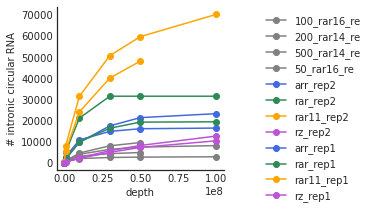

In [45]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    try:
        group.plot(x = 'depth', y = 'exon', ax = ax, 
                   label = rename_dict[name], marker = 'o',
                  color =group_color[rename_dict[name].split('_')[0]])
    except:
        group.plot(x = 'depth', y = 'intron', ax = ax, 
                   label = name, marker = 'o',
                  color ='grey')
    sns.despine()
ax.set_ylabel('# intronic circular RNA')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_exon_circ.pdf')

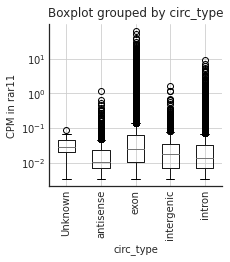

In [46]:
mega.boxplot(by = 'circ_type', column=['rar11_rep2'], figsize = (3,3), rot = 90)
plt.yscale('log')
plt.ylabel('CPM in rar11')
sns.despine()
plt.title('')
plt.savefig(figdir / '1_CPM_by_type.pdf')

In [47]:
mega['detected_by_other']=mega[[c for c in mega.columns if c.startswith('detected_') and 'rar11' not in c]].any(axis = 1)

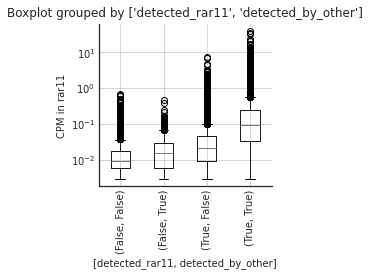

In [48]:
mega.boxplot(by = ['detected_rar11','detected_by_other'], column = 'rar11_rep1', figsize = (3,3),
            rot = 90)
sns.despine()
plt.yscale('log')
plt.ylabel('CPM in rar11')
plt.title('')
plt.savefig(figdir / '1_CPM_by_detect_rar11.pdf')

# Are intronic RNA lariats?

In [49]:
gencode_coords = BedTool('/home/hsher/gencode_coords/gencode.v35.basic.annotation.gff3')

In [ ]:
from collections import defaultdict
known_5ss = defaultdict(set)
known_3ss = defaultdict(set)
for record in gencode_coords:
    if record[2]=='exon':
        gene = record.attrs['gene_name']
        if record.strand == '+':
            ss3 = record.start
            ss5 = record.end+1
        else:
            ss3 = record.end+1
            ss5 = record.start
        known_5ss[gene].add(ss5)
        known_3ss[gene].add(ss3)

In [ ]:
intronic = mega.loc[(mega['circ_type']=='intron')&(mega['detected_rar11']), 
                   ['seqname', 'start', 'end', 'strand', 'gene_name']]
pos = intronic.loc[intronic['strand']=='+']
neg = intronic.loc[intronic['strand']=='-']
neg['5prime']=neg['end']
neg['3prime']=neg['start']

pos['3prime']=pos['end']
pos['5prime']=pos['start']
intronic = pd.concat([pos, neg], axis = 0)

In [ ]:
intronic['len']= intronic['end']-intronic['start']

In [ ]:
intronic

In [ ]:
intronic['hit_5ss']=intronic.apply(lambda row: int(row['5prime']) in known_5ss[row['gene_name']], axis = 1)

In [ ]:
intronic['hit_5ss'].value_counts()

In [ ]:
476/(7339+476)

In [ ]:
def closest_upstream_5ss(row):
    ss5_list = list(known_5ss[row['gene_name']])
    
    # if not ss5_list:
    #     return np.nan
    
    if row['strand']=='+':
        
        dist = [row['5prime']-s for s in ss5_list if row['5prime']-s >= 0]
        try:
            return min(dist)
        except:
            return np.nan
    else:
        dist = [row['5prime']-s for s in ss5_list if row['5prime']-s <= 0]
        try:
            return -max(dist)
        except:
            return np.nan

In [ ]:
def closest_downstream_3ss(row):
    ss3_list = list(known_3ss[row['gene_name']])
    
    # if not ss5_list:
    #     return np.nan
    
    if row['strand']=='+':
        
        dist = [row['3prime']-s for s in ss3_list if row['3prime']-s <= 0]
        try:
            return -max(dist)
        except:
            return np.nan
    else:
        dist = [row['3prime']-s for s in ss3_list if row['3prime']-s >= 0]
        try:
            return min(dist)
        except:
            return np.nan

In [ ]:
intronic['distance_to_closest_upstream_5ss']=intronic.apply(lambda row: closest_upstream_5ss(row), axis = 1)

In [ ]:
intronic['distance_to_closest_upstream_5ss'].hist()

In [ ]:
intronic['distance_to_closest_downstream_3ss']=intronic.apply(lambda row: closest_downstream_3ss(row), axis = 1)

In [ ]:
intronic.loc[intronic['hit_5ss'], 'distance_to_closest_downstream_3ss'].hist(range = (0,100),
                                                                            bins = 50)
plt.xlabel('distance_to_closest_downstream_3ss')
plt.ylabel('# intronic circle')

In [ ]:
intronic.loc[intronic['distance_to_closest_downstream_3ss']<0]

In [ ]:
intronic.loc[intronic['distance_to_closest_downstream_3ss']==0]

In [ ]:
lariat=intronic.loc[intronic['hit_5ss']]

In [ ]:
mega.loc[lariat.index]['detected_arr'].sum(),
mega.loc[lariat.index]['detected_arr'].sum(),

In [ ]:
lariat.shape

In [ ]:
intronic.loc[~intronic['hit_5ss'], 'distance_to_closest_downstream_3ss'].hist(range = (0,5000),
                                                                            bins = 50)
plt.xlabel('distance_to_closest_downstream_3ss')
plt.ylabel('# intronic circle')

In [ ]:
intronic.loc[~intronic['hit_5ss'], 'distance_to_closest_upstream_5ss'].hist(range = (0,10000),
                                                                            bins = 50)
plt.xlabel('distance_to_closest_upstream_5ss')
plt.ylabel('# intronic circle')

In [ ]:
intronic.loc[(intronic['distance_to_closest_downstream_3ss']<50)&
            ~intronic['hit_5ss']]